In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from mcc import (
    Contract,
    ResolvableContract,
    EuropeanOption,
    Zero,
    One,
    Give,
    Scale,
    And,
    Or,
    Delay,
    Until,
    At,
    KonstFloat,
    FX,
    GeometricBrownianMotion,
    Model,
    generate_simple_cashflows_in_currency,
)

In [2]:
@dataclass
class FxCall(ResolvableContract):
    fixing_date: np.datetime64
    payment_date: np.datetime64
    notional: float
    strike: float
    base_currency: str
    counter_currency: str

    def resolve(self) -> Contract:
        fw = self.strike * One(self.base_currency) - One(self.counter_currency)
        opt = Delay(
            At(self.payment_date), EuropeanOption(self.fixing_date, fw).resolve()
        )
        return self.notional * opt

In [3]:
maturity = np.datetime64("2021-06-01")
notional = 10_000_000
strike = 1 / 1.10
base_currency = "EUR"
counter_currency = "USD"

In [4]:
fxcall = FxCall(
    maturity, maturity + 2, notional, strike, base_currency, counter_currency
)
print(fxcall)

Scale(10000000, ShiftTo(2021-06-03, When(2021-06-01, Or(And(Scale(0.9090909090909091, One(EUR)), Give(One(USD))), Zero))))


In [5]:
spot = 1.15
volatility = 0.2
dategrid = np.array(
    [
        np.datetime64("2021-01-01"),
        np.datetime64("2021-02-01"),
        np.datetime64("2021-03-01"),
        np.datetime64("2021-04-01"),
        np.datetime64("2021-05-01"),
        np.datetime64("2021-06-01"),
        np.datetime64("2021-06-03"),
    ]
)
timegrid = np.linspace(0, 5 / 12, 6)
timegrid = np.hstack((timegrid, [timegrid[-1] + 2 / 365]))

(100, 7)

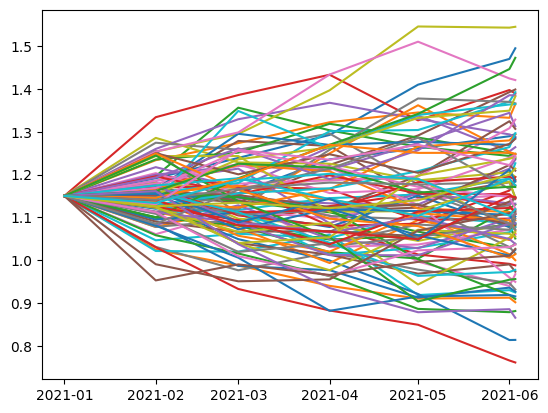

In [6]:
n = 100
rnd = np.random.RandomState(123)
gbm = GeometricBrownianMotion(mu_t=lambda t: 0, sigma=volatility)
x = spot * gbm.simulate(timegrid, n, rnd)
plt.plot(dategrid, x.T)
x.shape

In [7]:
model = Model(dategrid, {}, {("EUR", "USD"): x}, {}, np.ones(x.shape), "EUR")

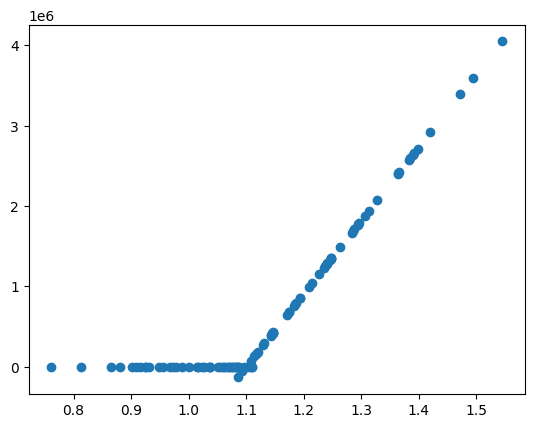

In [8]:
cf_usd = generate_simple_cashflows_in_currency(model, fxcall.resolve(), "USD")
plt.scatter(x[:, -1], cf_usd);

In [9]:
@dataclass
class FxKnockoutCall(FxCall):
    upper_barrier: float

    def resolve(self) -> Contract:
        return Until(
            FX(self.base_currency, self.counter_currency) >= self.upper_barrier,
            super().resolve(),
        )

In [10]:
upper_barrier = 1.3
fxkocall = FxKnockoutCall(
    maturity,
    maturity + 2,
    notional,
    strike,
    base_currency,
    counter_currency,
    upper_barrier,
)
print(fxkocall)

Until(FX(EUR/USD) >= 1.3, Scale(10000000, ShiftTo(2021-06-03, When(2021-06-01, Or(And(Scale(0.9090909090909091, One(EUR)), Give(One(USD))), Zero)))))


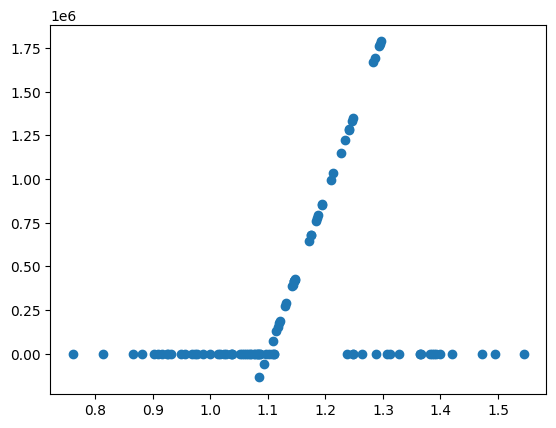

In [11]:
cf_usd = generate_simple_cashflows_in_currency(model, fxkocall.resolve(), "USD")
plt.scatter(x[:, -1], cf_usd);